## __Solving unsteady Darcy equations__


### Problem statement

We present the simulation of unsteady flow, i.e. the solution of the Darcy problem at different time steps, on a fractured rock with an impervious rock matrix.

<center>
<img src="img/heads_unsteady.png" width=800>
<br>
Evolution of heads inside a single fracture with time
</center>

### What will you learn ?

* Assign boundary condition <br>
* Assign storativity <br>
* Analyze the resulting flow.

### Theoretical background

The system of equations is slightly different from that of steady-state flow:
<center>
$  s \partial_t h + \nabla \cdot q = 0$ <br/>
$ q = T \nabla h $
</center>
<br>
with $h$ the hydraulic head, $q$ the Darcy flow, $T$ the transmissivity, and $s$ the storativity.
<br>
In DFN.lab, the time evolution is performed with an explicit Euler method.


### DFN.Lab model

Flow equations are solved on a meshed DFN.
<br>
Solving the Darcy equation in transient conditions is very similar to the steady-state problem. The reader is invited to read the associated tutorial. <br/> 

__________

### Example 1: Analytical problem of a single fracture

In this first example, we study the evolution of hydraulic heads with time in a single fracture. <br>
This is a verification problem with an analytical solution.

In [1]:
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn
import dfnlab.FlowBoundaryConditions as bc
import dfnlab.Mesh as mesh 
import dfnlab.Flow as flow
import dfnlab.MaterialProperties as mat
import numpy as np
import os

We consider a single fracture parallel to the $z$ axis, centered at the origin, crossing a cubic domain of size $1m$.

In [2]:
system = sys.System()
domain = dom.Domain()
domain.buildParallelepiped(center=[0, 0, 0], L1=1)
system.setDomain(domain)
fnet = dfn.DFN()
system.setDFN(fnet)
fr1 = dfn.Fracture([0., 0., 0.], 5 ,[0,0,1])
fnet.addFracture(fr1)
system.build();

A mesh of caracteristic length $0.05m$ is generated.

In [3]:
meshFnet = mesh.Mesh(system)
meshFnet.setCaracteristicLength(0.05)
meshFnet.setRefinementIntersection(1)
meshFnet.setGradationCoefficient(1.01)
meshFnet.generate();

#### Assigning storativity and transmissivity 

Storativity is a property of DFN, used in a similar way to transmissivity. <br>
It can be interpreted as the amount of compressibility of the flow. If the value is zero, the flow is incompressible. <br/>
In order to illustrate a case where storativity matters, we deliberately use a high value.
Here, the value of storativity is $4 m^{-1}$.

In [4]:
storativities = mat.DFNProperties(fnet)
storativities.setConstant(value=4.)
fnet.addProperties("storativities", storativities)

We assign constant transmsivity equal to $1 m^2 s^{-1}$.

In [6]:
transmissivities = mat.DFNProperties(fnet)
transmissivities.setConstant(value=1.)
fnet.addProperties("transmissivities", transmissivities)

#### Boundary condition

We apply permeameter conditions in the $x$ direction.

In [7]:
h0=10.
bc.FlowBoundaryCondition.setPermeameter(domain=domain, deltahead=h0, direction=np.array([1,0,0]))

#### Creation of the flow solver object:

We need an initial value: 

In [8]:
Flow = flow.DFNFlow(meshFnet) 

In this case, the hydraulic head is zero everywhere (default case).</br>
Then, we need a to create a Darcy problem. The linear system is updated at each time step. <br>

In [9]:
timeStep = 0.005
DarcyProblem = flow.createDarcyProblem(Flow , timeStep)

We solve the Darcy problem at each timestep

In [10]:
FinalTime1 = 0.1
t=0
while(t < FinalTime1):
    Flow.solveProblem(DarcyProblem)
    t = t + timeStep

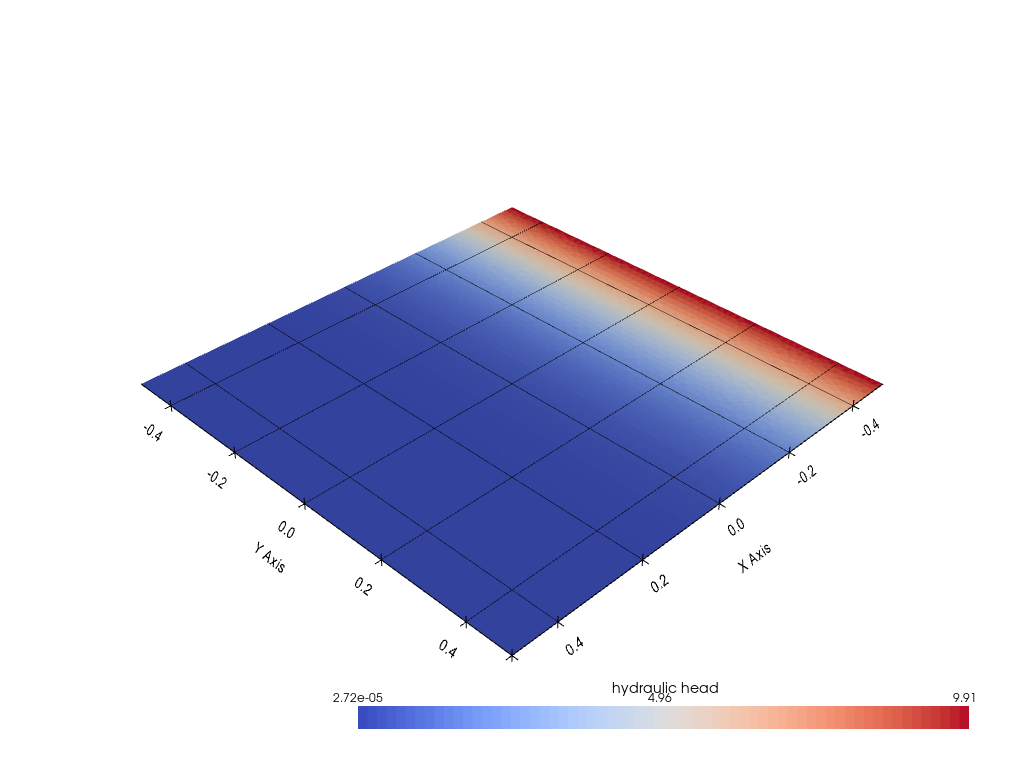

In [11]:
from sources.functions import plot_mesh
pathFolder = os.getcwd()+"/Tmp"
plot_mesh(meshFnet,Flow.getHead(),"hydraulic head")

Then, we solve the problem to go further in time:

In [12]:
FinalTime1 = 0.5

i=0
while(t < FinalTime1):
    Flow.solveProblem(DarcyProblem)
    t = t + timeStep
    import dfnlab.IO as io
    io.write_flow_file(Flow,"Tmp/unsteady="+str(i)+".vtp")
    i+=1

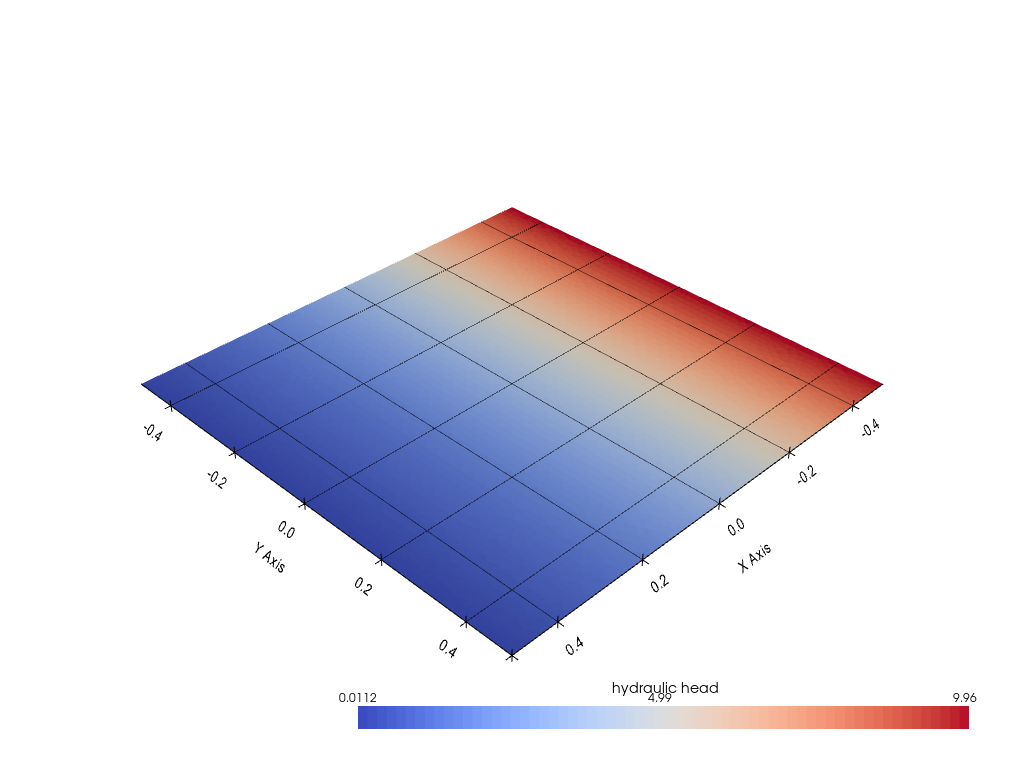

In [13]:
plot_mesh(meshFnet,Flow.getHead(),"hydraulic head")

#### Comparison with the analytical solution

The analytical solution is:
<font size="4">
$$ h^+(x^+,y^+,t^+) =  (\frac{l}{2}-x^+) + \frac{2}{\pi} \sum_{i=0}^{\infty} \frac{(-1)^n}{n} sin(n \pi(\frac{l}{2}-x^+)) e^{-(n\pi)^2t^+/(s p_ 0)}  $$ <br>
$$ x^+ = \frac{x}{l}, y^+ = \frac{y}{l}$$  <br>
$$ t^+ = \frac{tKh_0}{l^2}$$  <br>
$$ h^+ = \frac{h}{h_0} $$  <br>

We can thus compare the simulated values with the theoretical ones.

In [14]:
import vtk
import numpy as np
import math as lm

alpha = 10
s = 4
l = 1
K = 1
p0 = alpha
Tstar = l**2/(K*p0)


T = t 
N = 100 # limit of the summation
error= 0
hydraulicHead = Flow.getHead()
for elem in range(meshFnet.numTriangles()):
    triangle = meshFnet.getTriangle(elem)
    position =meshFnet.getTriangle(elem).getBarycenter()
    hh = hydraulicHead.val(triangle)
    if(hh):  
        h = hydraulicHead.val(triangle)/p0

        posX = position[0]
        AnalyticSolution = alpha*(0.5- posX/l)
        for n in range(1,N):
            AnalyticSolution =  AnalyticSolution + 2.*alpha/lm.pi*((-1)**n/n)*np.sin(n*lm.pi*((0.5- posX/l)))*np.exp(-(n*lm.pi)**2*T/Tstar/(s*p0))
        AnalyticSolution = AnalyticSolution / p0    
        error += abs(h-AnalyticSolution) 
error /=   (meshFnet.numTriangles())
print("The averaged absolute error is: {}".format(error))

print(error)

The averaged absolute error is: 0.0009047377759338868
0.0009047377759338868


_______________

### Example 2: Example with a 10 fracture DFN

We start by solving a steady state flow with permeameter conditions on a DFN. <br/>
Then we mimic a doublet test between two boreholes. <br/>
A pumping at constant head is performed at the first borehole, and then, after a time $t$, an injection starts at the second borehole. <br/>
Let start by solving the steady-state flow (with no actions in the wells).

In [17]:
import dfnlab.System as sys
import dfnlab.Domains as dom
import dfnlab.Fractures as dfn
import dfnlab.FlowBoundaryConditions as bc
import dfnlab.Mesh as mesh 
import dfnlab.Flow as flow
import dfnlab.MaterialProperties as mat
import dfnlab.IO as io
import numpy as np

import os

system = sys.System()
domain = dom.Domain()

system_size = 1
domain.buildParallelepiped(center=[0, 0, 0], L1=system_size)


system.setDomain(domain)

well1 = dom.Well1D([0.125,0,-25],[0.125,0,25])
well2 = dom.Well1D([-0.25,0,-25],[-0.25,0,25])

system.addGeometry(well1)
system.addGeometry(well2)                  
                     
fnet = dfn.DFN()
system.setDFN(fnet)
io.load_DFN_file(fnet,filename='sources/Ktest.disk', format="disk")


system.build()


meshDFN = mesh.Mesh(system)  
meshDFN.setCaracteristicLength(0.2)
meshDFN.setRefinementIntersection(3)
meshDFN.setGradationCoefficient(1.15)  
meshDFN.generate()

h0 =10
bc.FlowBoundaryCondition.setPermeameter(domain,h0,np.array([0,0,1]))
 
transmissivityValue =1.0

transmissivities = mat.DFNProperties(fnet)
transmissivities.setConstant(transmissivityValue)
fnet.addProperties("transmissivities", transmissivities)

storativityValue =4.0
storativities = mat.DFNProperties(fnet)
storativities.setConstant(storativityValue)
fnet.addProperties("storativities", storativities)

flow_system = flow.solveDarcyProblem(meshDFN)

Linear system building 
Taking account of the boundary conditions
Linear System solving


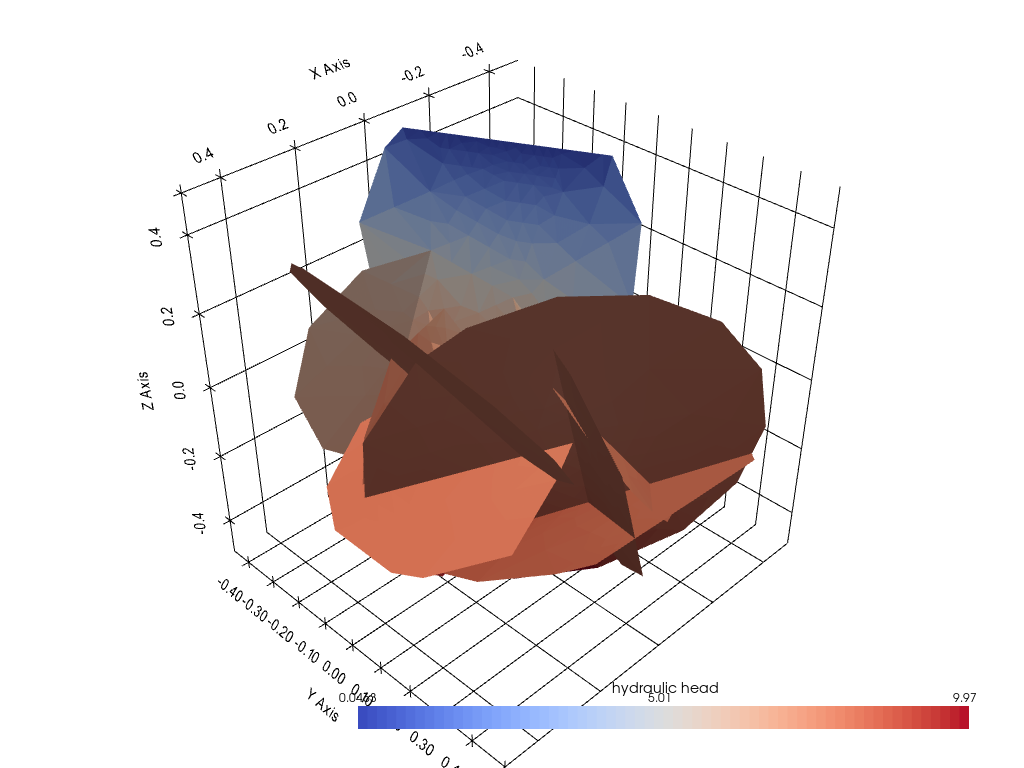

In [18]:
from sources.functions import *

pathFolder = os.getcwd()+"/Tmp"
plot_mesh(meshDFN,flow_system.getHead(),"hydraulic head")

Steady-state flow is considered as the initial values of the unsteady flow. <br/>
Pumping starts in the first borehole.

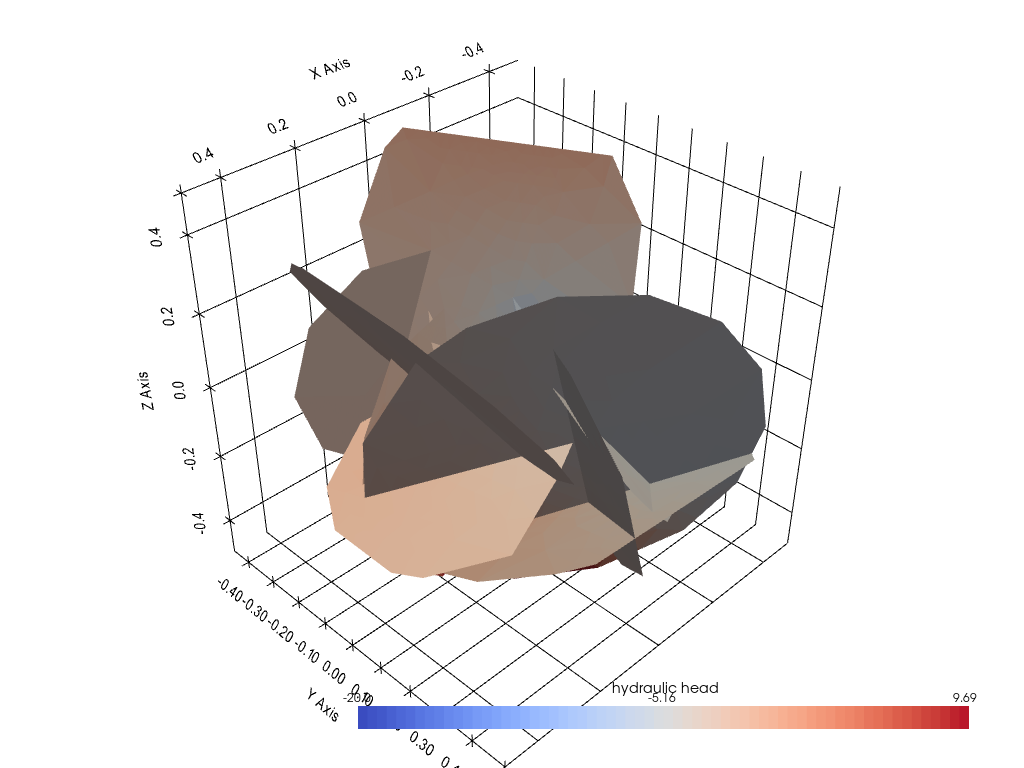

In [19]:
bc.FlowBoundaryCondition.setHead(well2,-20)

t=0
FinalTime1 =20
timeStep = 1

DarcyProblem = flow.createDarcyProblem(flow_system , timeStep)

while(t < FinalTime1):
    flow_system.solveProblem(DarcyProblem)
    t = t + timeStep

plot_mesh(meshDFN,flow_system.getHead(),"hydraulic head")

Finally, the injection starts:

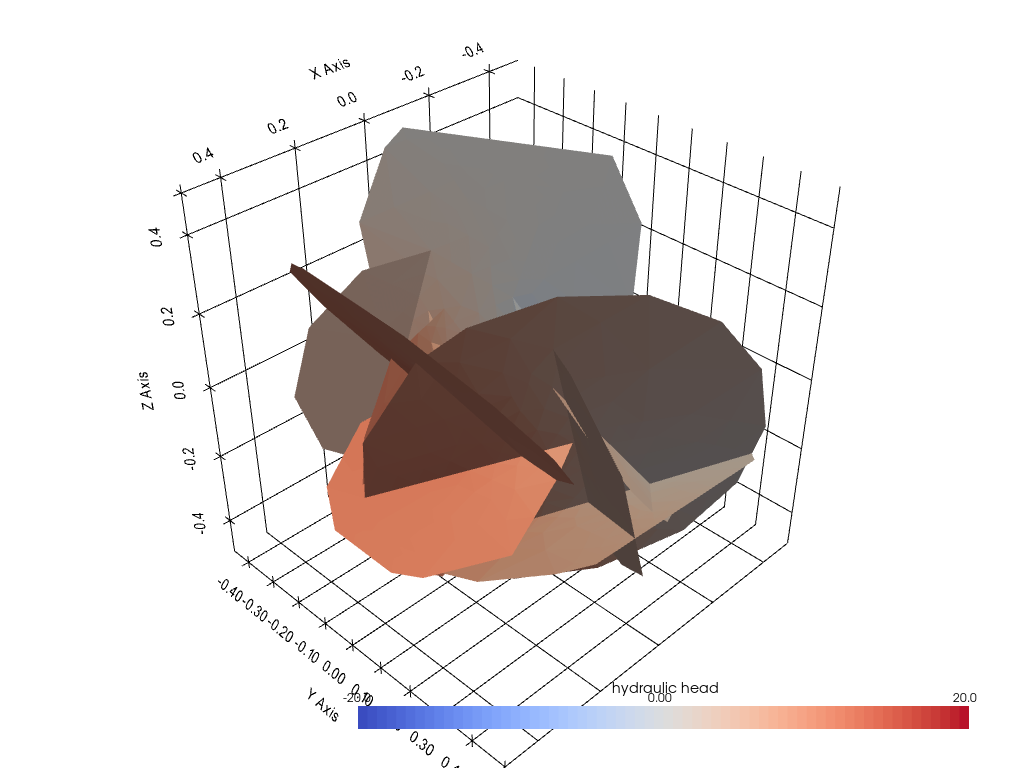

In [20]:
bc.FlowBoundaryCondition.setHead(well1,20)
FinalTime2 = 200

meshDFN.setBoundaryCondition()
while(t < FinalTime2):
    flow_system.solveProblem(DarcyProblem)
    t = t + timeStep

plot_mesh(meshDFN,flow_system.getHead(),"hydraulic head")

To test the convergence of the solution, we can compare with the steady state problem (with pumping/injection)

Linear system building 
Taking account of the boundary conditions
Linear System solving


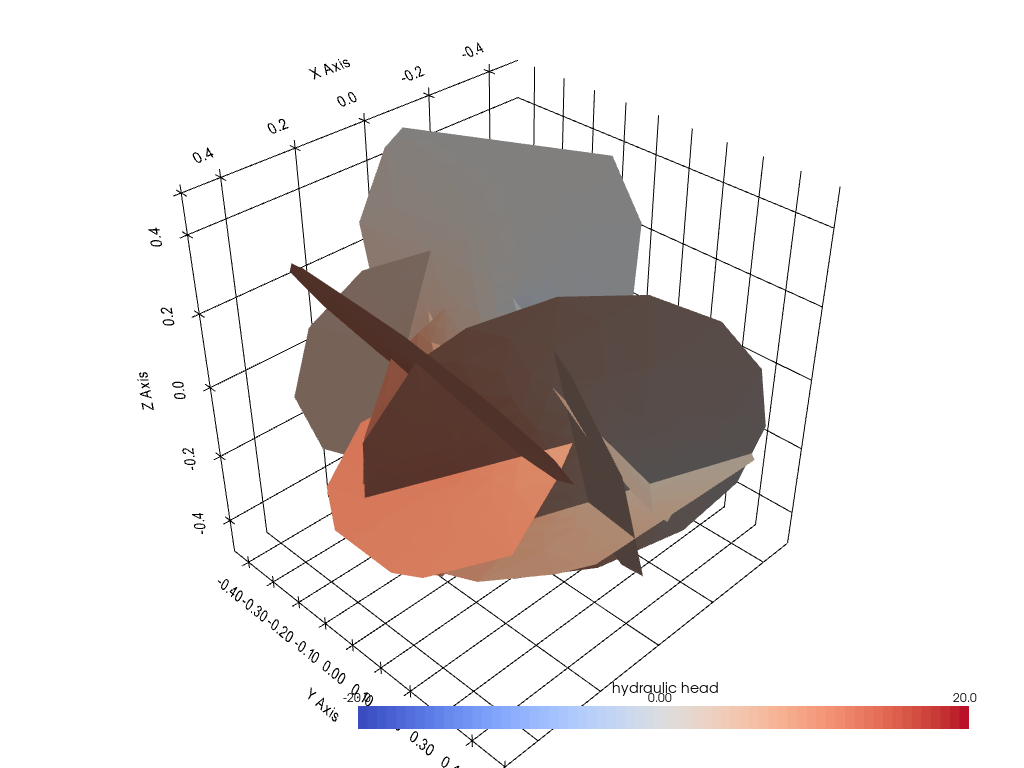

8196


In [21]:
flow_systemSteadyState = flow.solveDarcyProblem(meshDFN)

plot_mesh(meshDFN,flow_systemSteadyState.getHead(),"hydraulic head")
print(meshFnet.numTriangles())

Then, we compute the difference:

In [22]:
unSteadyH = flow_system.getHead()
steadyH = flow_systemSteadyState.getHead()


for elem in range(meshDFN.numTriangles()):
    triangle = meshDFN.getTriangle(elem)
    h1 = unSteadyH.val(triangle)
    h2 = steadyH.val(triangle)
    if(h1 and h2):
        error += abs(h1-h2)*triangle.getArea()
    else:
        print("bad array")
print("Difference between converged unsteady problem and steady state problem: {}".format(error))    

Difference between converged unsteady problem and steady state problem: 0.0009047377761650768
